In [ ]:
!pip install optuna
!pip install shap
!pip install lightgbm
!pip install optuna-integration[lightgbm]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings

#from sklearnex import patch_sklearn # no funciona bien con TSNE
#patch_sklearn()
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import shap
import tensorflow as tf

#import optuna
#from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold
#from optuna.samplers import TPESampler
from lightgbm import LGBMRegressor
import lightgbm

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
pd.options.display.max_columns = None

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

sns.set_style("darkgrid")
sns.set(font_scale=1.1)

# 1. Carga de Datos, Ajustes e incorporación de Lags y Variables Temporales Cíclicas

### Loading data, cleaning, preprocessing, feature engineering, and some EDA when applicable.

### **Loading the dataset as a Pandas DataFrame and setting the date/time column as the index with the correct data type.**

In [ ]:
onedrive_url = "https://uccl0-my.sharepoint.com/:u:/g/personal/cbasultom_estudiante_uc_cl/EdyUz0U9_7hFgQbZmnLsPR0BhaAfbZoNvwpM-LKX_GmUSA?e=DkeCD7"+"&download=1"
!mkdir -p /mnt/data
!mkdir -p /content/data
!wget -O /mnt/data/MiningProcess_Flotation_Plant_Database.zip "$onedrive_url"
!unzip -o /mnt/data/MiningProcess_Flotation_Plant_Database -d /content/data

# Ubicación de CSV en Notebook
file_path = '/content/data/MiningProcess_Flotation_Plant_Database.csv'

--2025-11-25 02:20:06--  https://uccl0-my.sharepoint.com/:u:/g/personal/cbasultom_estudiante_uc_cl/EdyUz0U9_7hFgQbZmnLsPR0BhaAfbZoNvwpM-LKX_GmUSA?e=DkeCD7&download=1
Resolving uccl0-my.sharepoint.com (uccl0-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to uccl0-my.sharepoint.com (uccl0-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/cbasultom_estudiante_uc_cl/Documents/TrabajoGraduacionMCD/MiningProcess_Flotation_Plant_Database.zip?ga=1 [following]
--2025-11-25 02:20:06--  https://uccl0-my.sharepoint.com/personal/cbasultom_estudiante_uc_cl/Documents/TrabajoGraduacionMCD/MiningProcess_Flotation_Plant_Database.zip?ga=1
Reusing existing connection to uccl0-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 53386037 (51M) [application/x-zip-compressed]
Saving to: ‘/mnt/data/MiningProcess_Flotation_Plant_Database.zip’

/mnt/data/MiningPro 100%[=========

In [ ]:
# Carga CSV y utilización de valores sin perder la continuidad desde 2017-03-29 12:00:00 a 2017-09-09 23:00:00
df = pd.read_csv(file_path,
                 decimal=",",parse_dates=["date"], index_col="date")
df = df.loc["2017-03-29 12:00:00":] # Acá se deja la cota inferior temporal
df = reduce_mem_usage(df, False) # Se realiza cast para reducir memoria en datos
df_cut = df.copy()
df_before = df.copy().loc[:'2017-04-10 00:00:00']
df_after = df.copy().loc['2017-04-10 01:00:00':]
new_date = pd.to_datetime('2017-04-10 00:00:00')
new_data = pd.DataFrame(df_before[-1:].values, index=[new_date], columns=df_before.columns) # Agrega dato faltante en hora 2017-04-10 00:00:00
df_before = pd.concat([df_before,new_data],axis=0)

df = pd.concat([df_before, df_after])
df.reset_index(allow_duplicates=True, inplace=True)

df["duration"] = 20
df.loc[0,"duration"] = 0
df.duration = df.duration.cumsum()

df['Date_with_seconds'] = pd.Timestamp("2017-03-29 12:00:00") + pd.to_timedelta(df['duration'], unit='s')

df = df.set_index("Date_with_seconds")

df = df.drop(["index","duration"],axis=1)
df_h = df.resample('H').first()
df_h.index.names = ['Date']


tenemos dos dataframes:

df --> con 710.640 registros desde 2017-03-29 12:00:00 hasta 2017-09-09 23:59:40

df_h --> con 3.948 registros desde 2017-03-29 12:00:00 hasta 2017-09-09 23:00:00

In [ ]:
# Incorporación de características cíclicas que permiten modelar patrones recurrentes diarios y semanales
df_h["hora"] = df_h.index.hour
df_h['sin_hora'] = np.sin(2 * np.pi * df_h["hora"]/24) # sin_hora corresponde a sin de la hora/(24 horas)
df_h['cos_hora'] = np.cos(2 * np.pi * df_h["hora"]/24) # cos_hora corresponde a cos de la hora/(24 horas)

# Days of week  Monday = 0, sunday = 6
df_h["dia_de_la_semana"] = df_h.index.day_of_week
df_h['sin_dia_de_la_semana'] = np.sin(2 * np.pi * df_h["dia_de_la_semana"]/7)
df_h['cos_dia_de_la_semana'] = np.cos(2 * np.pi * df_h["dia_de_la_semana"]/7)

feat_eng_vars = ['sin_hora','cos_hora','sin_dia_de_la_semana','cos_dia_de_la_semana']
feat_eng_df = df_h[feat_eng_vars]
df_h = df_h.drop(["hora","dia_de_la_semana"],axis=1)
df_h = df_h.drop("% Silica Concentrate",axis=1)
df_h3=df_h.copy()    # Dataframe utilizado para LightGBM

### Incorporación de LAGs intra horarios (-15, -30 y -45 minutos)

In [ ]:
list_cols = [col for col in df.columns.to_list()]  # Use this if I want to include all explanatory variables.

list_cols.remove("% Silica Concentrate")
list_cols.remove("% Iron Concentrate")

# Resample the original df every 15 minutes.
df_15 = df.resample("15min").first()
df_15 = df_15.drop("% Silica Concentrate", axis=1)

# df_15 --> con 15.792 registros de 2017-03-29 12:00:00 a 2017-09-09 23:45:00

window_size = 3

# Taking advantage of the time factor, I add lagged explanatory variables at 15min, 30min, and 45min, respectively
# (these are the ones that were updated every 20s)

for col_name in list_cols:
    for i in range(window_size):
        df_15[f"{col_name} ({-15*(i+1)}mins)"] = df_15[f"{col_name}"].shift(periods=i+1)

# Resample from 15min to 1hour
df_h = df_15.resample('h').first()
# Here I change the name of my index.
df_h.index.names = ['Date']
df_h.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Iron Feed (-15mins),% Iron Feed (-30mins),% Iron Feed (-45mins),% Silica Feed (-15mins),% Silica Feed (-30mins),% Silica Feed (-45mins),Starch Flow (-15mins),Starch Flow (-30mins),Starch Flow (-45mins),Amina Flow (-15mins),Amina Flow (-30mins),Amina Flow (-45mins),Ore Pulp Flow (-15mins),Ore Pulp Flow (-30mins),Ore Pulp Flow (-45mins),Ore Pulp pH (-15mins),Ore Pulp pH (-30mins),Ore Pulp pH (-45mins),Ore Pulp Density (-15mins),Ore Pulp Density (-30mins),Ore Pulp Density (-45mins),Flotation Column 01 Air Flow (-15mins),Flotation Column 01 Air Flow (-30mins),Flotation Column 01 Air Flow (-45mins),Flotation Column 02 Air Flow (-15mins),Flotation Column 02 Air Flow (-30mins),Flotation Column 02 Air Flow (-45mins),Flotation Column 03 Air Flow (-15mins),Flotation Column 03 Air Flow (-30mins),Flotation Column 03 Air Flow (-45mins),Flotation Column 04 Air Flow (-15mins),Flotation Column 04 Air Flow (-30mins),Flotation Column 04 Air Flow (-45mins),Flotation Column 05 Air Flow (-15mins),Flotation Column 05 Air Flow (-30mins),Flotation Column 05 Air Flow (-45mins),Flotation Column 06 Air Flow (-15mins),Flotation Column 06 Air Flow (-30mins),Flotation Column 06 Air Flow (-45mins),Flotation Column 07 Air Flow (-15mins),Flotation Column 07 Air Flow (-30mins),Flotation Column 07 Air Flow (-45mins),Flotation Column 01 Level (-15mins),Flotation Column 01 Level (-30mins),Flotation Column 01 Level (-45mins),Flotation Column 02 Level (-15mins),Flotation Column 02 Level (-30mins),Flotation Column 02 Level (-45mins),Flotation Column 03 Level (-15mins),Flotation Column 03 Level (-30mins),Flotation Column 03 Level (-45mins),Flotation Column 04 Level (-15mins),Flotation Column 04 Level (-30mins),Flotation Column 04 Level (-45mins),Flotation Column 05 Level (-15mins),Flotation Column 05 Level (-30mins),Flotation Column 05 Level (-45mins),Flotation Column 06 Level (-15mins),Flotation Column 06 Level (-30mins),Flotation Column 06 Level (-45mins),Flotation Column 07 Level (-15mins),Flotation Column 07 Level (-30mins),Flotation Column 07 Level (-45mins)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-29 12:00:00,60.180000,9.34,2044.989990,349.911011,405.625000,9.74604,1.649650,200.393005,195.733994,201.826004,295.096008,306.399994,250.600998,251.001999,555.264465,552.255554,614.984741,428.429993,413.661987,447.886993,464.868988,66.440002,60.18,60.18,60.18,9.34,9.34,9.34,2044.989990,2044.989990,2044.989990,349.911011,349.911011,349.911011,405.625000,405.625000,405.625000,9.74604,9.74604,9.74604,1.649650,1.64965,1.649650,200.393005,200.393005,200.393005,195.733994,195.733994,195.733994,201.826004,201.826004,201.826004,295.096008,295.096008,295.096008,306.399994,306.399994,306.399994,250.600998,250.600998,250.600998,251.001999,251.001999,251.001999,555.264465,555.264465,555.264465,552.255554,552.255554,552.255554,614.984741,614.984741,614.984741,428.429993,428.429993,428.429993,413.661987,413.661987,413.661987,447.886993,447.886993,447.886993,464.868988,464.868988,464.868988
2017-03-29 13:00:00,60.180000,9.34,2510.360107,306.635010,402.303009,9.63786,1.524512,200.164993,194.285995,201.929001,295.096008,306.399994,250.194000,250.188004,851.772766,809.863892,881.307251,447.542999,421.278992,446.696991,413.321991,66.570000,60.18,60.18,60.18,9.34,9.34,9.34,348.284027,1764.400024,1316.302856,370.484009,423.773987,407.856995,406.557770,398.798004,396.552002,9.45473,9.41445,9.56653,1.526098,1.57831,1.556330,200.289993,199.951004

### Incorporación de LAGs de "% Iron Concentrate" para -1, -2 y -3 horas

In [ ]:
# Add lagged values of the target variable as explanatory variables, lagged by 1, 2, and 3 hours respectively.
# Se agrega el valor de "% Iron Concentrate" 1, 2 y 3 horas antes al set datos
col_name = "% Iron Concentrate"

df_h2= df_h.copy() # Variables que no consideran el LAG de "% Iron Concentrate"

window_size = 3
for i in range(window_size):
    df_h[f"{col_name} ({-i-1}h)"] = df_h[f"{col_name}"].shift(periods=i+1)

# Add the columns of hour and day of the week created previously in the preprocessing stage.
# Se agregan los valores de sin y cos de ls hora del día y día de la semana
df_h = pd.concat([df_h, feat_eng_df], axis=1)
# Make the target variable the first column.
x = df_h.columns.to_list()
x.remove("% Iron Concentrate")
x.insert(0, "% Iron Concentrate")

df_h = df_h[x]

df_h = df_h.dropna()  # Remove rows with missing values due to the shift().
df_h = df_h.astype("float32")  # Convert data to float32 for faster computation.
df_h.head()

,% Iron Concentrate,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Feed (-15mins),% Iron Feed (-30mins),% Iron Feed (-45mins),% Silica Feed (-15mins),% Silica Feed (-30mins),% Silica Feed (-45mins),Starch Flow (-15mins),Starch Flow (-30mins),Starch Flow (-45mins),Amina Flow (-15mins),Amina Flow (-30mins),Amina Flow (-45mins),Ore Pulp Flow (-15mins),Ore Pulp Flow (-30mins),Ore Pulp Flow (-45mins),Ore Pulp pH (-15mins),Ore Pulp pH (-30mins),Ore Pulp pH (-45mins),Ore Pulp Density (-15mins),Ore Pulp Density (-30mins),Ore Pulp Density (-45mins),Flotation Column 01 Air Flow (-15mins),Flotation Column 01 Air Flow (-30mins),Flotation Column 01 Air Flow (-45mins),Flotation Column 02 Air Flow (-15mins),Flotation Column 02 Air Flow (-30mins),Flotation Column 02 Air Flow (-45mins),Flotation Column 03 Air Flow (-15mins),Flotation Column 03 Air Flow (-30mins),Flotation Column 03 Air Flow (-45mins),Flotation Column 04 Air Flow (-15mins),Flotation Column 04 Air Flow (-30mins),Flotation Column 04 Air Flow (-45mins),Flotation Column 05 Air Flow (-15mins),Flotation Column 05 Air Flow (-30mins),Flotation Column 05 Air Flow (-45mins),Flotation Column 06 Air Flow (-15mins),Flotation Column 06 Air Flow (-30mins),Flotation Column 06 Air Flow (-45mins),Flotation Column 07 Air Flow (-15mins),Flotation Column 07 Air Flow (-30mins),Flotation Column 07 Air Flow (-45mins),Flotation Column 01 Level (-15mins),Flotation Column 01 Level (-30mins),Flotation Column 01 Level (-45mins),Flotation Column 02 Level (-15mins),Flotation Column 02 Level (-30mins),Flotation Column 02 Level (-45mins),Flotation Column 03 Level (-15mins),Flotation Column 03 Level (-30mins),Flotation Column 03 Level (-45mins),Flotation Column 04 Level (-15mins),Flotation Column 04 Level (-30mins),Flotation Column 04 Level (-45mins),Flotation Column 05 Level (-15mins),Flotation Column 05 Level (-30mins),Flotation Column 05 Level (-45mins),Flotation Column 06 Level (-15mins),Flotation Column 06 Level (-30mins),Flotation Column 06 Level (-45mins),Flotation Column 07 Level (-15mins),Flotation Column 07 Level (-30mins),Flotation Column 07 Level (-45mins),% Iron Concentrate (-1h),% Iron Concentrate (-2h),% Iron Concentrate (-3h),sin_hora,cos_hora,sin_dia_de_la_semana,cos_dia_de_la_semana
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-29 15:00:00,66.410004,60.180000,9.34,458.079010,476.877991,400.173004,9.75149,1.63844,199.951004,191.455994,199.264999,295.096008,306.399994,247.809006,249.582001,858.052246,778.343079,883.777161,438.032990,446.859009,423.183990,483.157013,60.180000,60.180000,60.180000,9.34,9.34,9.34,430.672821,2366.899902,2081.189941,489.502014,486.614990,471.627014,397.040009,399.304993,398.610992,9.69672,9.69206,9.69410,1.665510,1.658410,1.633150,199.731003,200.203003,199.886002,193.837997,195.292007,194.084000,198.852997,201.511993,201.658997,295.096008,295.096008,295.096008,306.399994,306.399994,306.399994,246.656998,249.893005,249.414001,251.005005,251.485992,250.268997,859.129028,844.704041,847.780945,777.324036,776.304993,775.285950,875.245422,882.022339,884.391663,469.598999,455.915985,484.032013,460.937012,433.328003,429.221008,459.109009,445.734985,453.789001,483.610992,457.071991,389.161987,66.639999,66.570000,66.440002,-0.707107,-7.071068e-01,0.974928,-0.222521
2017-03-29 16:00:00,63.630001,59.540001,9.56,145.349625,252.087997,399.484009,9.96978,1.52108,199.072006,182.429993,201.251007,295.096008,306.399994,250.488007,250.759995,853.745117,782.419312,883.715820,435.285004,434.662994,452.

## **Esto es importante pero no para contarlo en el vídeo**

Hay filas que el valor de la variable objetivo se repite más de tres veces seguidas. Esto se debe a los problemas temporales (...mencionados en la etapa de preprocesamiento: la variable objetivo no se actualiza en ciertos intervalos), pero si elimino esas filas afectará la continuidad temporal de los datos.

# 2. Modelos

### Metricas a Utilizar

In [ ]:
def timeseries_models_tracker_df():
    reg_models_scores_df = pd.DataFrame(
        columns=["model_name", "MAE", "RMSE", "MASE", "R2", "MAPE"])

    return reg_models_scores_df

def timeseries_report_model(y_test, model_preds, tracker_df="none", model_name="model_unknown", seasonality=1, naive=False):
    mae = round(mean_absolute_error(y_test, model_preds), 4)
    rmse = round(mean_squared_error(y_test, model_preds) ** 0.5, 4)
    mase = round(mean_absolute_scaled_error(y_test, model_preds, seasonality, naive),4)
    r2 = round(r2_score(y_test, model_preds), 4)
    mape = round(mean_absolute_percentage_error(y_test, model_preds), 4)

    print("MAE: ", mae)
    print("RMSE :", rmse)
    print("MASE :", mase)
    print("R2 :", r2)
    print("MAPE :", mape)

    if isinstance(tracker_df, pd.core.frame.DataFrame):
        tracker_df.loc[tracker_df.shape[0]] = [
            model_name, mae, rmse, mase, r2, mape]
    else:
        pass

def mean_absolute_scaled_error(y_true, y_pred, seasonality=1, naive=False):
    """
    Implement MASE (assuming no seasonality of data).
    """
    y_true = np.array(y_true)
    #y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    if naive:
        mae_naive_no_season = np.mean(np.abs(y_true - y_pred))

    else :
        mae_naive_no_season = np.mean(np.abs(y_true[seasonality:] - y_true[:-seasonality])) # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season


# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [ ]:
def plot_time_series(timesteps, values, start=0, end=None, label=None):#, #color="blue"):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None
    """
  # Plot the series
    sns.lineplot(x=timesteps[start:end], y=values[start:end], label=label)
    plt.xlabel("Date")
    plt.ylabel("% Iron Concentrate")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.xticks(rotation=45)
    plt.grid(True)

## 2.1 Modelo ingenuo

In [ ]:
y_true = df_h["% Iron Concentrate"]
x_true = df_h["% Iron Concentrate (-1h)"]

In [ ]:
y_true

,% Iron Concentrate
Date,
2017-03-29 15:00:00,66.410004
2017-03-29 16:00:00,63.630001
2017-03-29 17:00:00,66.190002
2017-03-29 18:00:00,66.260002
2017-03-29 19:00:00,66.279999
...,...
2017-09-09 19:00:00,65.050003
2017-09-09 20:00:00,64.830002
2017-09-09 21:00:00,64.290001


In [ ]:
split_size = int(len(y_true) * (1-0.1))
y_true = y_true[split_size:]
x_true = x_true[split_size:]

In [ ]:
len(y_true), len( x_true)

(395, 395)

In [ ]:
tracker = timeseries_models_tracker_df()

In [ ]:
timeseries_report_model(y_true, x_true, tracker, model_name="Modelo Ingenuo", seasonality=1, naive=True)

MAE:  0.6185
RMSE : 0.8719
MASE : 1.0
R2 : 0.4374
MAPE : 0.0096


In [ ]:
tracker

,model_name,MAE,RMSE,MASE,R2,MAPE
0,Modelo Ingenuo,0.6185,0.8719,1.0,0.4374,0.0096


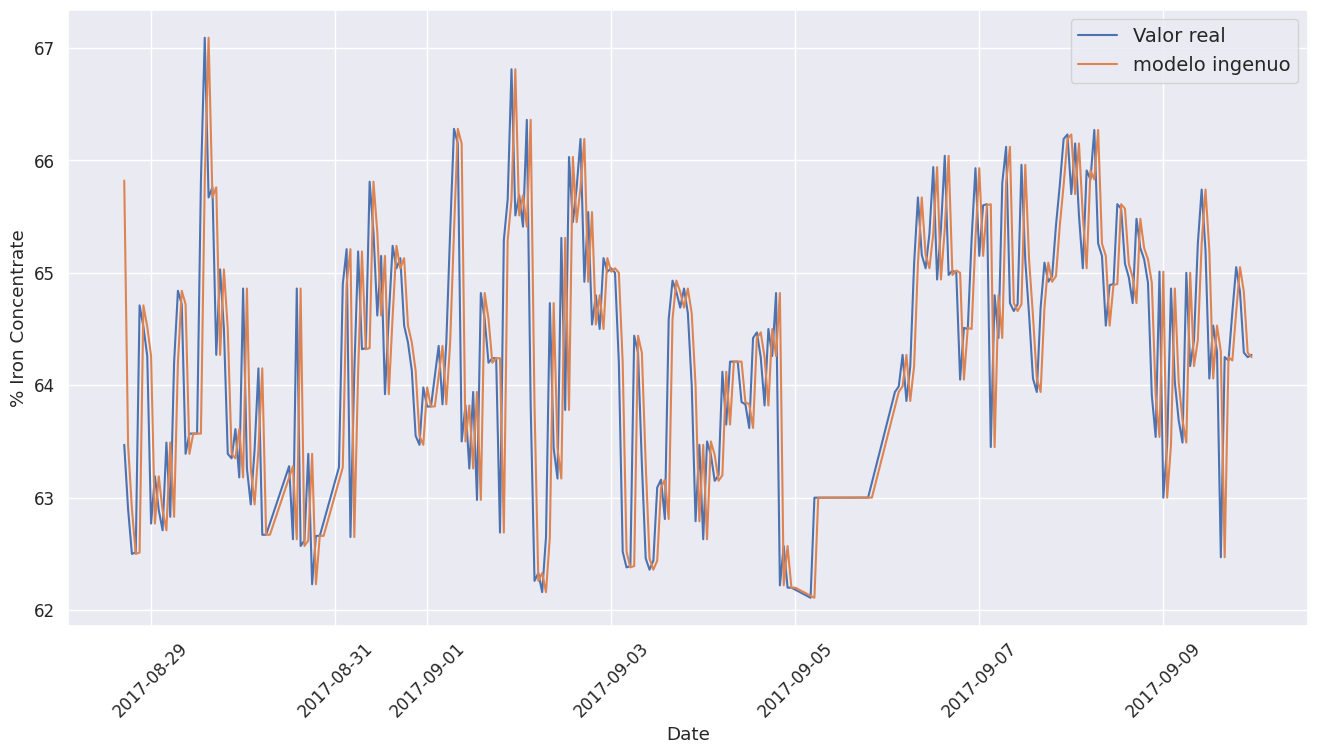

In [ ]:
plt.figure(figsize=(16,8),dpi=100)
plot_time_series(y_true.index, y_true, label="Valor real", start=100)
plot_time_series(x_true.index, x_true,label="modelo ingenuo", start=100)

## 2.2 LIGHTGBM




In [ ]:
df_forecast = df_h3.copy()

In [ ]:
X = df_forecast.drop("% Iron Concentrate",axis=1)
y = df_forecast["% Iron Concentrate"]

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(X,y,test_split=0.1)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import optuna
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler


def objective(trial, X, y):
    param_grid = {
        "random_state": 123,
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "device_type": trial.suggest_categorical("device_type", ["cpu"]),
        "n_estimators": trial.suggest_int("n_estimators", 25, 2025, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 190),
        "max_depth": trial.suggest_int("max_depth", 2, 80),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 800, step=20),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1e3, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1e3, log=True),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0, step=0.1),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [0, 1]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0, step=0.1),
        "objective": "regression",
        "silent": True,
    }

    def l2_rmse(y_true, y_pred):
        val = np.sqrt(mean_squared_error(y_true, y_pred))
        return "l2", float(val), False

    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []

    for tr_idx, va_idx in tscv.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model = LGBMRegressor(**param_grid)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            categorical_feature="auto",
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0),
                LightGBMPruningCallback(trial, "l2", report_interval=20)
            ],
        )

        preds = model.predict(X_va)
        cv_scores.append(np.sqrt(mean_squared_error(y_va, preds)))

    return np.mean(cv_scores)

In [ ]:

# ---- Ejecución Optuna ----
study = optuna.create_study(
    direction="minimize",
    study_name="LGBM Regressor",
    sampler=TPESampler()
)

func = lambda trial: objective(trial, train_windows, train_labels)
study.optimize(func, n_trials=100)

[I 2025-11-25 02:23:21,655] A new study created in memory with name: LGBM Regressor
[I 2025-11-25 02:23:21,903] Trial 0 finished with value: 1.094978260400254 and parameters: {'boosting_type': 'gbdt', 'device_type': 'cpu', 'n_estimators': 1325, 'learning_rate': 0.08246585889781295, 'num_leaves': 188, 'max_depth': 8, 'min_child_samples': 310, 'reg_alpha': 438.6170831126347, 'reg_lambda': 173.46697857226036, 'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.5}. Best is trial 0 with value: 1.094978260400254.
[I 2025-11-25 02:23:22,189] Trial 1 finished with value: 1.086535083155405 and parameters: {'boosting_type': 'gbdt', 'device_type': 'cpu', 'n_estimators': 325, 'learning_rate': 0.10691387585354127, 'num_leaves': 34, 'max_depth': 32, 'min_child_samples': 270, 'reg_alpha': 0.0039211452084379275, 'reg_lambda': 670.4257818785084, 'subsample': 0.4, 'subsample_freq': 1, 'colsample_bytree': 0.5}. Best is trial 1 with value: 1.086535083155405.
[I 2025-11-25 02:23:22,427] Trial 2 fi

In [ ]:
#mejores hyperparametros, sin variables explicativas mas alla de variable objetivo retrasada.
params = study.best_params
model = LGBMRegressor(objective="regression",random_state=123,**params)
model.fit(train_windows, train_labels)

LGBMRegressor(colsample_bytree=0.4, device_type='cpu',
              learning_rate=0.07797002717910476, max_depth=9,
              min_child_samples=450, n_estimators=1025, num_leaves=28,
              objective='regression', random_state=123,
              reg_alpha=0.2783879773788911, reg_lambda=1.743040607251971,
              subsample=0.6000000000000001, subsample_freq=1)

In [ ]:
preds = model.predict(test_windows)

In [ ]:
timeseries_report_model(test_labels, preds, tracker, model_name="Experimento 2, LightGBM",
                        seasonality=1, naive=False)

MAE:  0.977
RMSE : 1.2268
MASE : 1.5807
R2 : -0.1139
MAPE : 0.0153


In [ ]:
tracker

,model_name,MAE,RMSE,MASE,R2,MAPE
0,Modelo Ingenuo,0.6185,0.8719,1.0000,0.4374,0.0096
1,"Experimento 2, LightGBM",0.9770,1.2268,1.5807,-0.1139,0.0153


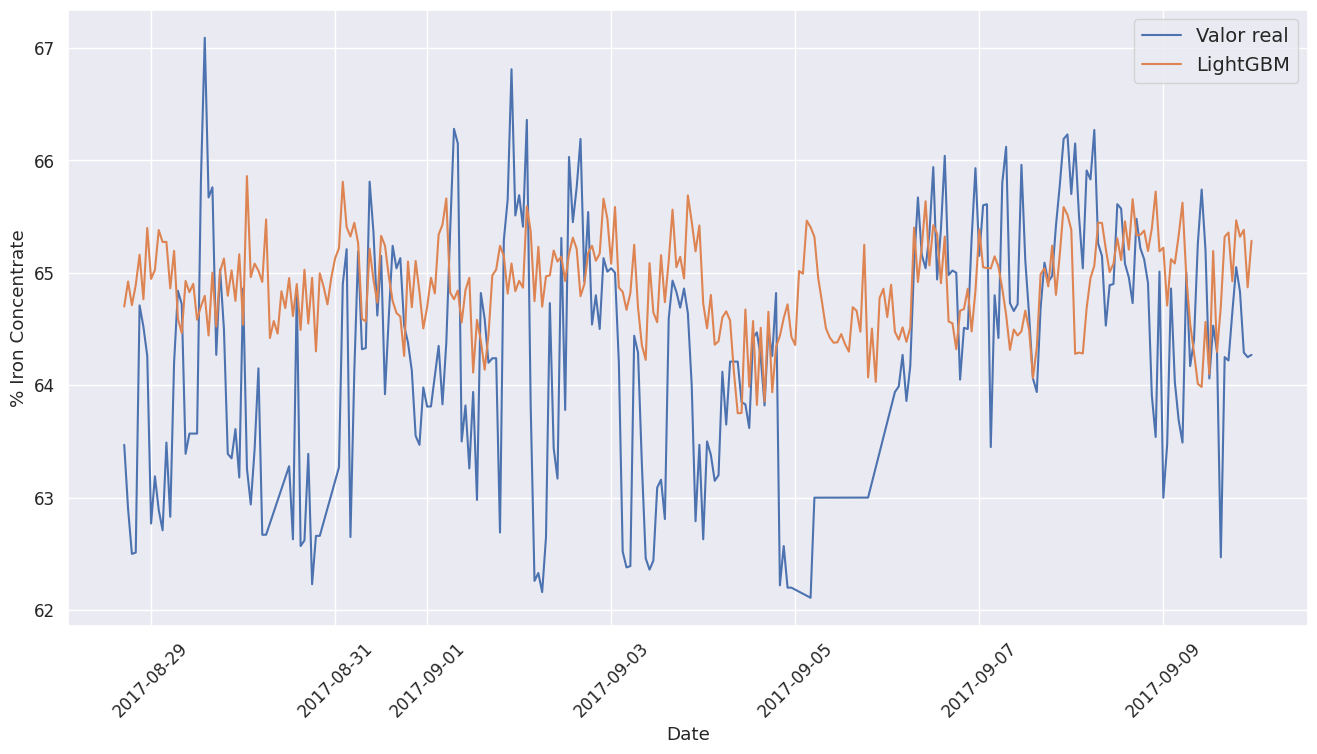

In [ ]:
plt.figure(figsize=(16,8),dpi=100)
plot_time_series(test_labels.index, test_labels, label="Valor real", start=100)
plot_time_series(test_labels.index, preds,label="LightGBM", start=100)

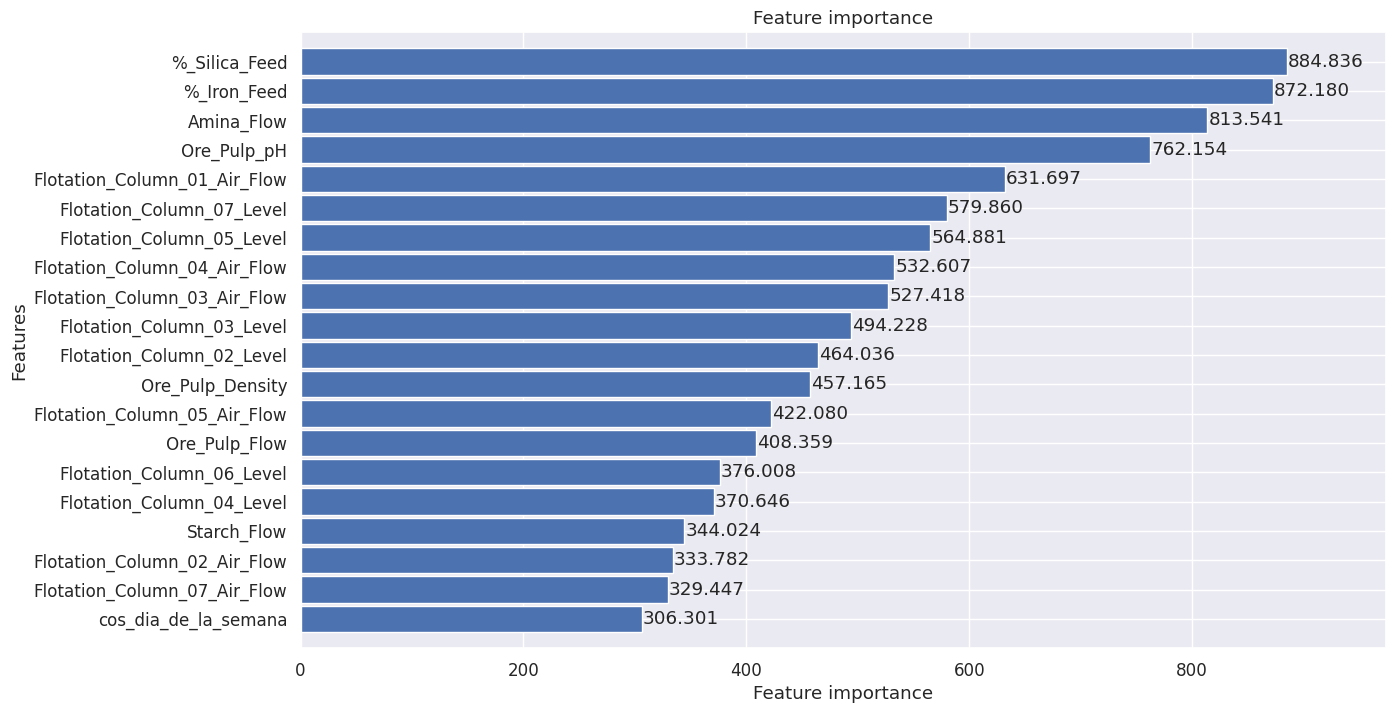

In [ ]:
from lightgbm import plot_importance
#If "split", result contains numbers of times the feature is used in a model.
#plt.figure(figsize=(14,10),dpi=100)
plot_importance(model, max_num_features = 20, height=.9, importance_type="gain", figsize=(14,8)); # puedo usar tambien importance_type = "split"

In [ ]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(test_windows)

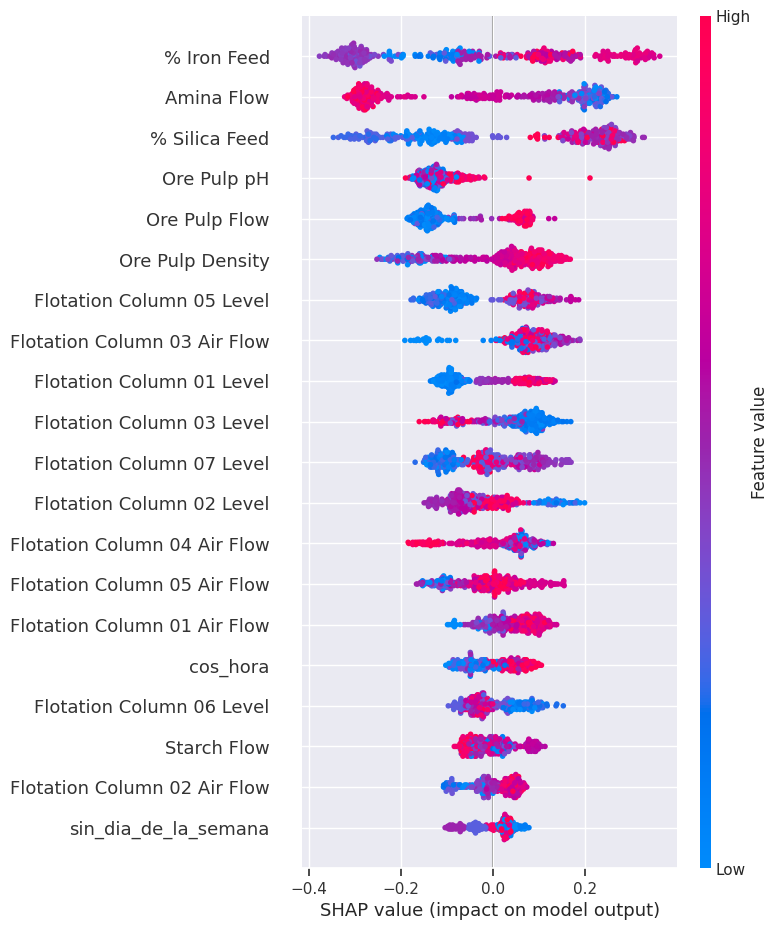

In [ ]:
shap.summary_plot(shap_values, test_windows)

### 2.3 LSTM (pocas variables)

I will use a neural network with a layer of "Long Short-Term Memory" (LSTM), which are known to be quite good at univariate and **multivariate** time series problems. They have the benefit of retaining information from past time steps, whose information may be relevant for predicting the current time step accurately.

An LSTM (Long Short-Term Memory) neural network is a type of recurrent neural network that is capable of processing sequential data, such as time series or natural language. It is particularly useful for tasks that involve long-term dependencies, where information from earlier time steps is still relevant to the current time step.

The key feature of an LSTM network is the use of "memory cells," which are units that can retain information for a prolonged period of time. These cells are controlled by three types of gates: the input gate, the forget gate, and the output gate. The input gate controls the flow of new information into the cell, the forget gate controls the flow of information out of the cell, and the output gate controls the flow of information out of the cell and into the rest of the network.

I'm going to scale the data, as neural networks perform better when the different variables move in similar magnitudes.

I will use MinMaxScaler.

In [ ]:
df_forecast = df_h.copy()

for col in df_forecast.columns:
    if "% Iron Conc" not in col:
        df_forecast.drop(f"{col}",axis=1,inplace=True)

scaler = MinMaxScaler()
scaler.fit(df_forecast)
df_lstm_simple = pd.DataFrame(scaler.transform(df_forecast), index= df_forecast.index, columns=df_forecast.columns)

X = df_lstm_simple.drop("% Iron Concentrate",axis=1).astype("float32")
y = df_lstm_simple["% Iron Concentrate"].astype("float32")


print(X.shape, y.shape)

(3945, 3) (3945,)


In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(X,y,test_split=0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3550, 395, 3550, 395)

I use different callbacks during training. I am using "loss" instead of "val_loss" for the callbacks, as it can theoretically cause data leakage since the validation set I used is actually the test set.

In [ ]:
from pathlib import Path

# 1) Definir y crear la carpeta de checkpoints
ckpt_dir = Path("weights_checkpoints/timeseries_model_lstm")
ckpt_dir.mkdir(parents=True, exist_ok=True)

# 2) Ruta del archivo de checkpoint (modelo completo en formato .keras)
checkpoint_path = ckpt_dir / "cp.keras"

# 3) Callbacks
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",  # o 'val_loss' si pasas validación en model.fit
    patience=20,
    restore_best_weights=True,
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_path),
    monitor="loss",       # o 'val_loss'
    save_best_only=True,
    save_weights_only=False,  # guarda el modelo completo
    verbose=1,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",  # o 'val_loss'
    patience=10,
    factor=0.2,
    verbose=1,
)


In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
horizon = 1 #remember this

# 1. Construct model
inputs = tf.keras.layers.Input(shape=(train_windows.shape[1],))  # -> (timesteps,)
x = tf.keras.layers.Reshape((train_windows.shape[1], 1))(inputs) # -> (timesteps, 1)
x = tf.keras.layers.LSTM(128, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
output = tf.keras.layers.Dense(horizon, activation="linear")(x)

model = tf.keras.Model(inputs, output, name="model_lstm_1h_forecast")


# 2. Compile
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=["mae"])

# 3. Fit the model
model.fit(x=train_windows,
            y=train_labels,
            epochs=120,
            verbose=1,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint,earlystopping, reduce_lr])

Epoch 1/120
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2683 - mae: 0.2683
Epoch 1: loss improved from inf to 0.16473, saving model to weights_checkpoints/timeseries_model_lstm/cp.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.2665 - mae: 0.2665 - val_loss: 0.1147 - val_mae: 0.1147 - learning_rate: 5.0000e-04
Epoch 2/120
105/111 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0951 - mae: 0.0951
Epoch 2: loss improved from 0.16473 to 0.09237, saving model to weights_checkpoints/timeseries_model_lstm/cp.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0949 - mae: 0.0949 - val_loss: 0.1027 - val_mae: 0.1027 - learning_rate: 5.0000e-04
Epoch 3/120
109/111 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0891 - mae: 0.0891
Epoch 3: loss improved from 0.09237 to 0.08853, saving model to weights_checkpoints/timeseries_model_lstm/cp.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0891 - mae: 0.0891 - val_loss: 0.1005 - val_mae: 0.1005 - learning_rate: 5.0000e-04
Epoch

In [ ]:
from tensorflow import keras
best_model = keras.models.load_model("weights_checkpoints/timeseries_model_lstm/cp.keras",
                                     safe_mode=False)

In [ ]:
preds = pd.Series(best_model.predict(test_windows).reshape(-1), index=test_windows.index)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [ ]:
y_real = pd.concat((test_labels, test_windows), axis=1)
y_real = scaler.inverse_transform(y_real)

y_pred = pd.concat((preds,test_windows), axis=1)
y_pred = scaler.inverse_transform(y_pred)

test_labelss = y_real[:,0]
preds = y_pred[:,0]

In [ ]:
from tensorflow import keras
import tensorflow as tf
import os, json, time, platform
from pathlib import Path
from joblib import dump

BUNDLE_DIR = Path("lstm_bundle")
BUNDLE_DIR.mkdir(parents=True, exist_ok=True)

best_model_path = "weights_checkpoints/timeseries_model_lstm/cp.keras"
best_model = keras.models.load_model(best_model_path, safe_mode=False)

# 1) Guardar en formato Keras (recomendado y suficiente para la mayoría)
model_out = BUNDLE_DIR / "model.keras"
best_model.save(model_out)

# 2) (Opcional) Exportar para TF Serving
savedmodel_dir = BUNDLE_DIR / "savedmodel"
try:
    # Keras 3+
    best_model.export(str(savedmodel_dir))
    print("SavedModel exportado con model.export()")
except AttributeError:
    # Keras 2.x (si realmente lo necesitas)
    tf.saved_model.save(best_model, str(savedmodel_dir))
    print("SavedModel exportado con tf.saved_model.save()")

# 3) Guardar scaler y columnas
dump(scaler, BUNDLE_DIR / "scaler.joblib")
with open(BUNDLE_DIR / "feature_names.json", "w", encoding="utf-8") as f:
    json.dump(list(df_forecast.columns), f, ensure_ascii=False, indent=2)

# 4) Metadatos
meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "python_version": platform.python_version(),
    "tensorflow_version": tf.__version__,
    "keras_backend": tf.keras.backend.backend(),
    "target": "% Iron Concentrate",
    "window_shape_train": list(getattr(train_windows, "shape", [])),
    "window_shape_test": list(getattr(test_windows, "shape", [])),
    "horizon": 1,
    "loss": "mae",
    "optimizer": "adam",
    "learning_rate": 0.0005,
}
with open(BUNDLE_DIR / "manifest.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ Bundle guardado en:", BUNDLE_DIR)

Saved artifact at 'lstm_bundle/savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_layer_2')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137658268998096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137658268998672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137658268998480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137658671616208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137658671615440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137658671621776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137658671623504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137658671612752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137658671621392: TensorSpec(shape=(), dtype=tf.resource, name=None)
SavedModel exportado con model.export()
✅ Bundle guardado en: lstm_bundle


In [ ]:
import shutil
from google.colab import files

zip_path = shutil.make_archive("lstm_bundle", "zip", "lstm_bundle")
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We see that our recurrent neural network model (LSTM) outperforms the naive model in all metrics (although by a small margin).

In [ ]:
timeseries_report_model(test_labelss,preds, tracker, model_name="Experimento 3, LSTM (pocas variables)", seasonality=1, naive=False)

MAE:  0.5963
RMSE : 0.8265
MASE : 0.9649
R2 : 0.4943
MAPE : 0.0093


In [ ]:
tracker

,model_name,MAE,RMSE,MASE,R2,MAPE
0,Modelo Ingenuo,0.6185,0.8719,1.0000,0.4374,0.0096
1,"Experimento 2, LightGBM",0.9770,1.2268,1.5807,-0.1139,0.0153
2,"Experimento 3, LSTM (pocas variables)",0.5963,0.8265,0.9649,0.4943,0.0093


In [ ]:
explainer = shap.KernelExplainer(model, shap.sample(train_windows, 100))

In [ ]:
shap_values = explainer.shap_values(test_windows, nsamples=100)

  0%|          | 0/395 [00:00<?, ?it/s]

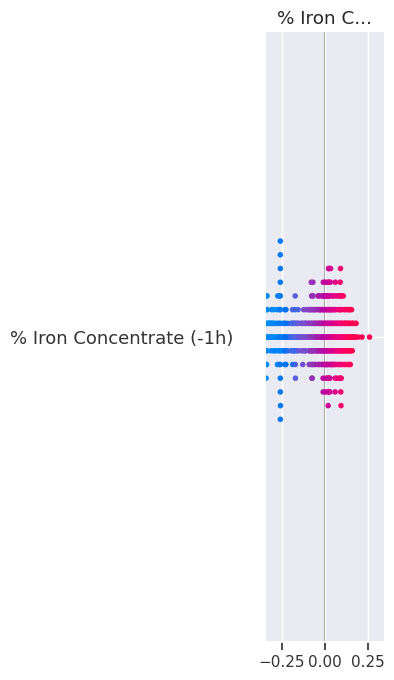

In [ ]:
shap.summary_plot(shap_values, test_windows) #,feature_names=features)

According to the impact of explanatory variables shown by SHAP, we see that our model is largely learning from the previous lag, as it often replicates it in the graph. That's why a delay is observed in the graph. It's clear that the model made some minor modifications and was able to beat the naive model.

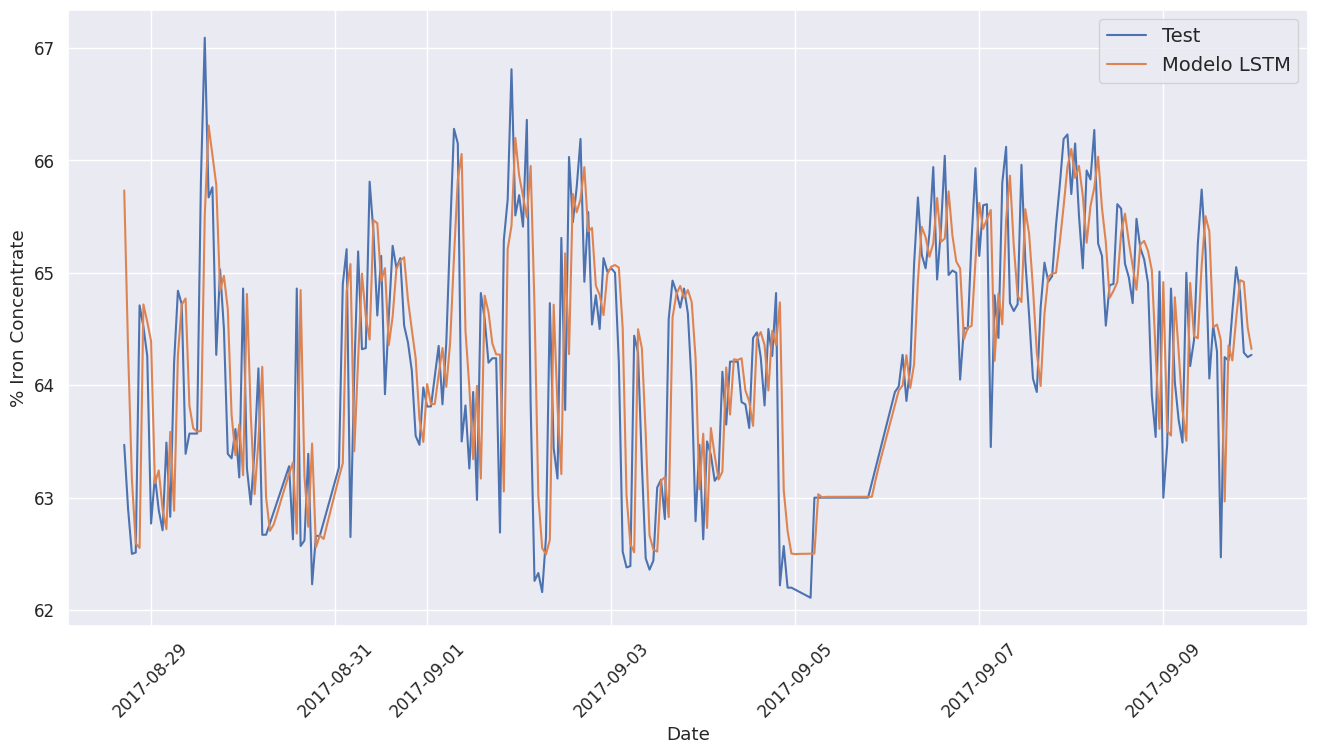

In [ ]:
plt.figure(figsize=(16,8),dpi=100)
#plot_time_series(df.index[window_size:2224+window_size],y_train.reshape(-1),label="Train", start=1500)
plot_time_series(test_labels.index[-len(test_windows):],test_labelss, label="Test", start=100)
plot_time_series(test_labels.index[-len(test_windows):],preds.reshape(-1),label="Modelo LSTM", start=100)

### 2.4 LSTM

In [ ]:
df_forecast = df_h.copy()
# drop Date column

scaler = MinMaxScaler()
scaler.fit(df_forecast)
df_lstm_simple = pd.DataFrame(scaler.transform(df_forecast), index= df_forecast.index, columns=df_forecast.columns)

X = df_lstm_simple.drop("% Iron Concentrate",axis=1).astype("float32")
y = df_lstm_simple["% Iron Concentrate"].astype("float32")


print(X.shape, y.shape)

(3945, 91) (3945,)


In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(X,y,test_split=0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3550, 395, 3550, 395)

In [ ]:
from pathlib import Path

# 1) Definir y crear la carpeta de checkpoints
ckpt_dir = Path("weights_checkpoints/timeseries_model_lstm")
ckpt_dir.mkdir(parents=True, exist_ok=True)

# 2) Ruta del archivo de checkpoint (modelo completo en formato .keras)
checkpoint_path = ckpt_dir / "cp.keras"

# 3) Callbacks
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",  # o 'val_loss' si pasas validación en model.fit
    patience=20,
    restore_best_weights=True,
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_path),
    monitor="loss",       # o 'val_loss'
    save_best_only=True,
    save_weights_only=False,  # guarda el modelo completo
    verbose=1,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",  # o 'val_loss'
    patience=10,
    factor=0.2,
    verbose=1,
)


In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
horizon = 1 #remember this

# 1. Construct model
inputs = tf.keras.layers.Input(shape=(train_windows.shape[1],))  # -> (timesteps,)
x = tf.keras.layers.Reshape((train_windows.shape[1], 1))(inputs) # -> (timesteps, 1)
x = tf.keras.layers.LSTM(128, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
output = tf.keras.layers.Dense(horizon, activation="linear")(x)

model = tf.keras.Model(inputs, output, name="model_lstm_1h_forecast")


# 2. Compile
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=["mae"])

# 3. Fit the model
model.fit(x=train_windows,
            y=train_labels,
            epochs=120,
            verbose=1,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint,earlystopping, reduce_lr])

Epoch 1/120
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2494 - mae: 0.2494
Epoch 1: loss improved from inf to 0.17351, saving model to weights_checkpoints/timeseries_model_lstm/cp.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - loss: 0.2487 - mae: 0.2487 - val_loss: 0.1614 - val_mae: 0.1614 - learning_rate: 5.0000e-04
Epoch 2/120
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1311 - mae: 0.1311
Epoch 2: loss improved from 0.17351 to 0.12786, saving model to weights_checkpoints/timeseries_model_lstm/cp.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 0.1310 - mae: 0.1310 - val_loss: 0.1489 - val_mae: 0.1489 - learning_rate: 5.0000e-04
Epoch 3/120
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1201 - mae: 0.1201
Epoch 3: loss improved from 0.12786 to 0.11987, saving model to weights_checkpoints/timeseries_model_lstm/cp.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - loss: 0.1201 - mae: 0.1201 - val_loss: 0.1392 - val_mae: 0.1392 - learning_rate: 5.00

In [ ]:
from tensorflow import keras
best_model = keras.models.load_model("weights_checkpoints/timeseries_model_lstm/cp.keras",
                                     safe_mode=False)

In [ ]:
preds = pd.Series(best_model.predict(test_windows).reshape(-1), index=test_windows.index)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [ ]:
y_real = pd.concat((test_labels, test_windows), axis=1)
y_real = scaler.inverse_transform(y_real)

y_pred = pd.concat((preds,test_windows), axis=1)
y_pred = scaler.inverse_transform(y_pred)

test_labelss = y_real[:,0]
preds = y_pred[:,0]

In [ ]:
timeseries_report_model(test_labelss,preds, tracker, model_name="Experimento 4, LSTM", seasonality=1, naive=False)

MAE:  0.6619
RMSE : 0.8761
MASE : 1.0709
R2 : 0.4318
MAPE : 0.0103


In [ ]:
explainer = shap.KernelExplainer(model, shap.sample(train_windows, 100))

In [ ]:
shap_values = explainer.shap_values(test_windows, nsamples=100)

  0%|          | 0/395 [00:00<?, ?it/s]

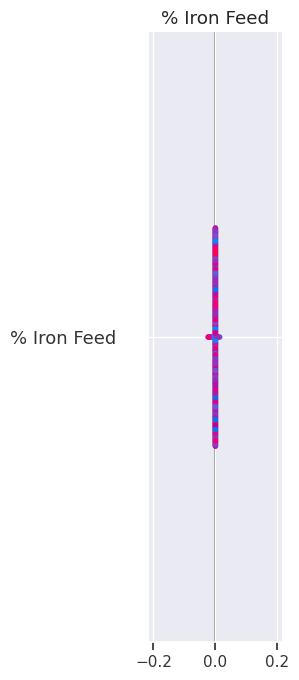

In [ ]:
shap.summary_plot(shap_values, test_windows) #,feature_names=features)

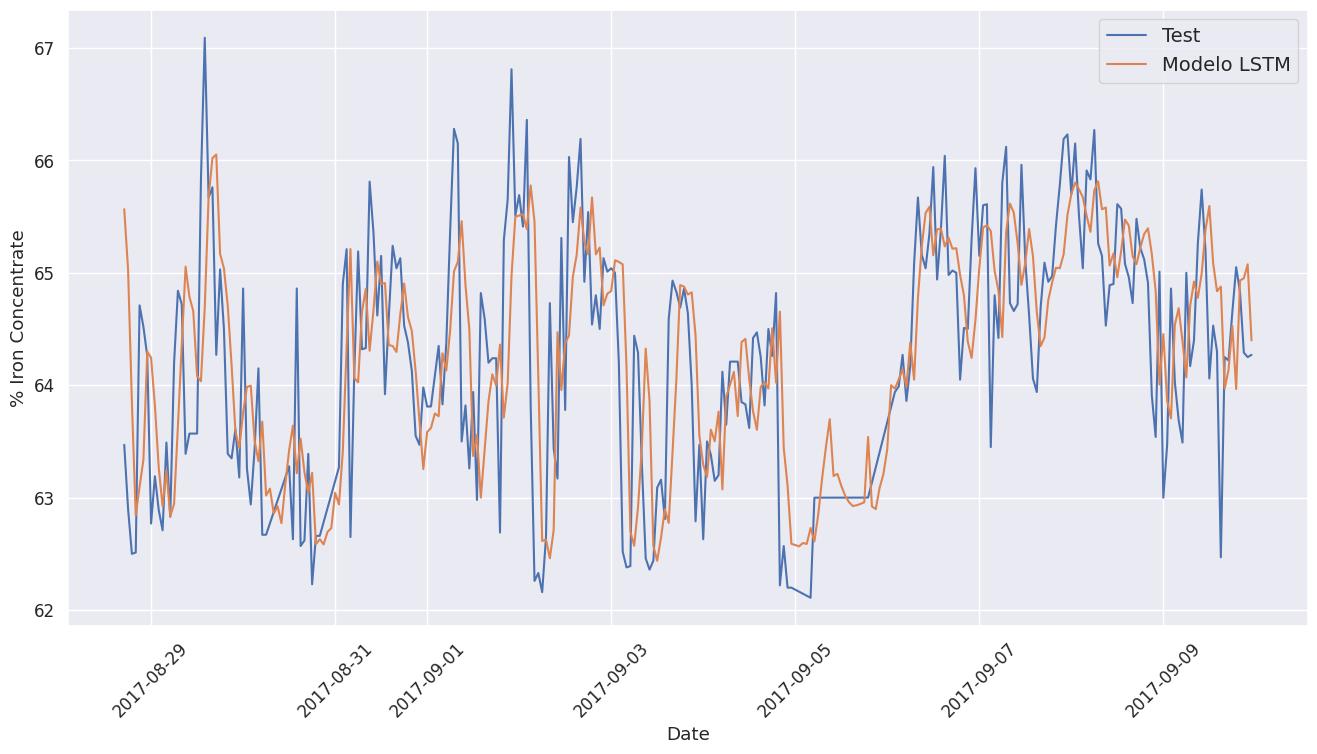

In [ ]:
plt.figure(figsize=(16,8),dpi=100)
#plot_time_series(df.index[window_size:2224+window_size],y_train.reshape(-1),label="Train", start=1500)
plot_time_series(test_labels.index[-len(test_windows):],test_labelss, label="Test", start=100)
plot_time_series(test_labels.index[-len(test_windows):],preds.reshape(-1),label="Modelo LSTM", start=100)

In [ ]:
tracker

,model_name,MAE,RMSE,MASE,R2,MAPE
0,Modelo Ingenuo,0.6185,0.8719,1.0000,0.4374,0.0096
1,"Experimento 2, LightGBM",0.9770,1.2268,1.5807,-0.1139,0.0153
2,"Experimento 3, LSTM (pocas variables)",0.5963,0.8265,0.9649,0.4943,0.0093
3,"Experimento 4, LSTM",0.6619,0.8761,1.0709,0.4318,0.0103


### 2.5 Modelo baseline estático: Partial Least Squares (PLS)



In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Usamos el dataset horario completo df_h (todas las variables) tal como en el LSTM multivariable estático
df_forecast = df_h.copy()

X = df_forecast.drop("% Iron Concentrate", axis=1)
y = df_forecast["% Iron Concentrate"].astype("float32")

print("Shape X:", X.shape, "Shape y:", y.shape)

Shape X: (3945, 91) Shape y: (3945,)


In [ ]:
# División temporal 90/10, consistente con el resto de los modelos
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(X, y, test_split=0.1)
print("Train size:", train_windows.shape, "Test size:", test_windows.shape)

Train size: (3550, 91) Test size: (395, 91)


In [ ]:
# Selección del número de componentes mediante validación temporal sobre el conjunto de entrenamiento
max_components = min(15, train_windows.shape[1])  # límite superior razonable
tscv = TimeSeriesSplit(n_splits=5)

best_n_comp = None
best_rmse = float("inf")

for n_comp in range(2, max_components + 1):
    rmses = []
    for train_idx, val_idx in tscv.split(train_windows):
        X_tr, X_val = train_windows.iloc[train_idx], train_windows.iloc[val_idx]
        y_tr, y_val = train_labels.iloc[train_idx], train_labels.iloc[val_idx]

        pls = PLSRegression(n_components=n_comp, scale=True)
        pls.fit(X_tr, y_tr)

        y_val_pred = pls.predict(X_val).reshape(-1)
        rmses.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

    mean_rmse = np.mean(rmses)
    print(f"n_components={n_comp}, RMSE_val={mean_rmse:.4f}")
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_n_comp = n_comp

print(f"Mejor número de componentes PLS: {best_n_comp}, RMSE_val={best_rmse:.4f}")

n_components=2, RMSE_val=0.8886
n_components=3, RMSE_val=0.8239
n_components=4, RMSE_val=0.7678
n_components=5, RMSE_val=0.7633
n_components=6, RMSE_val=0.7508
n_components=7, RMSE_val=0.7380
n_components=8, RMSE_val=0.7629
n_components=9, RMSE_val=0.7367
n_components=10, RMSE_val=0.7338
n_components=11, RMSE_val=0.7429
n_components=12, RMSE_val=0.7439
n_components=13, RMSE_val=0.7505
n_components=14, RMSE_val=0.7662
n_components=15, RMSE_val=0.7857
Mejor número de componentes PLS: 10, RMSE_val=0.7338


In [ ]:
# Entrenamiento final del modelo PLS con el mejor número de componentes
pls_final = PLSRegression(n_components=best_n_comp, scale=True)
pls_final.fit(train_windows, train_labels)

# Predicciones en el conjunto de test
test_pred = pls_final.predict(test_windows).reshape(-1)
preds = pd.Series(test_pred, index=test_windows.index)

In [ ]:
# Reporte de métricas con el mismo esquema que el resto de modelos
timeseries_report_model(test_labels, preds, tracker,
                        model_name="Experimento 5, PLS estático (baseline Fase A, df_h)",
                        seasonality=1, naive=False)

MAE:  0.609
RMSE : 0.8039
MASE : 0.9853
R2 : 0.5216
MAPE : 0.0095


In [ ]:
tracker

,model_name,MAE,RMSE,MASE,R2,MAPE
0,Modelo Ingenuo,0.6185,0.8719,1.0000,0.4374,0.0096
1,"Experimento 2, LightGBM",0.9770,1.2268,1.5807,-0.1139,0.0153
2,"Experimento 3, LSTM (pocas variables)",0.5963,0.8265,0.9649,0.4943,0.0093
3,"Experimento 4, LSTM",0.6619,0.8761,1.0709,0.4318,0.0103
4,"Experimento 5, PLS estático (baseline Fase A, ...",0.6090,0.8039,0.9853,0.5216,0.0095


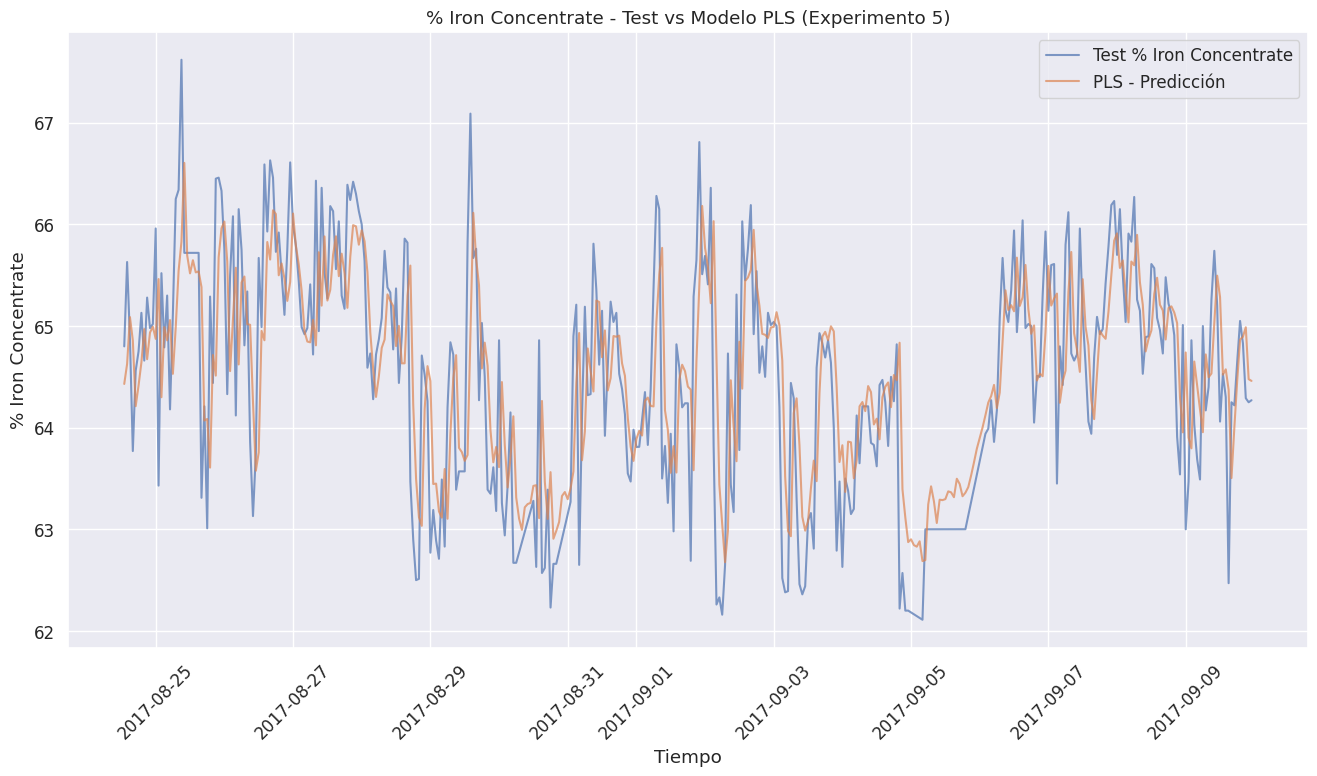

In [ ]:
# Gráficos para el modelo 2.5 PLS: Test vs Modelo y "importancia" de variables vía coeficientes

import matplotlib.pyplot as plt

# 1) Gráfico Test vs Modelo (serie de tiempo)
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(test_labels.index, test_labels, label="Test % Iron Concentrate", alpha=0.7)
plt.plot(preds.index, preds, label="PLS - Predicción", alpha=0.7)
plt.title("% Iron Concentrate - Test vs Modelo PLS (Experimento 5)")
plt.xlabel("Tiempo")
plt.ylabel("% Iron Concentrate")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


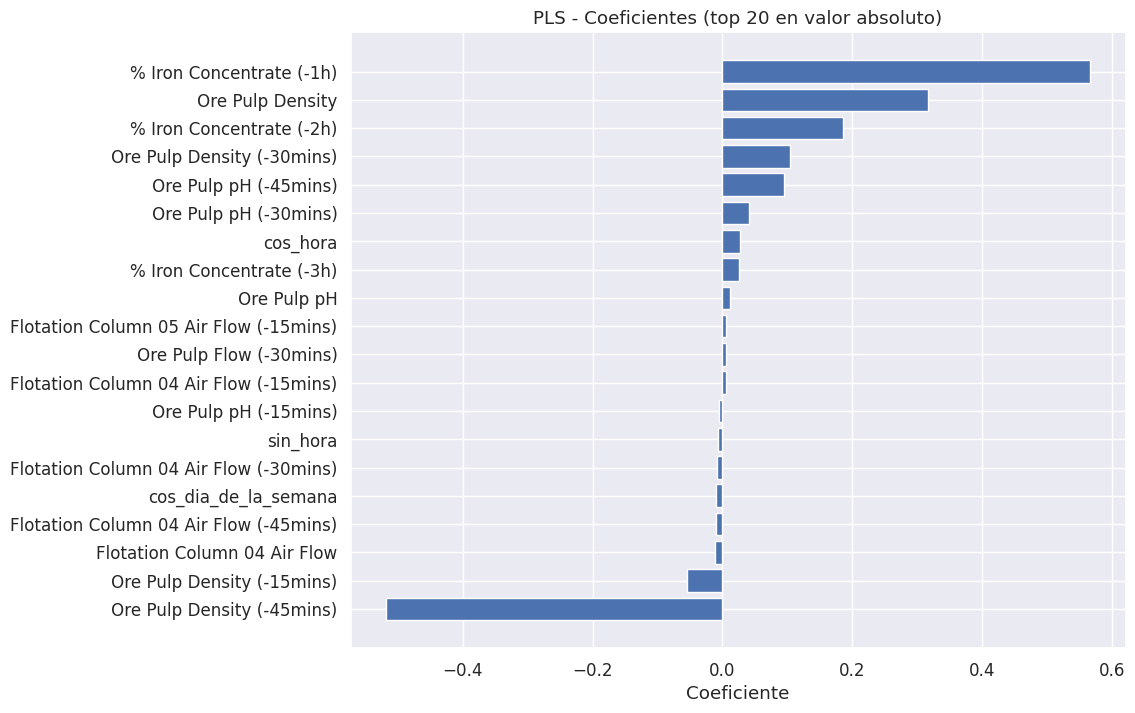

In [ ]:

# 2) "Importancia" de variables según coeficientes PLS
coef = pls_final.coef_.ravel()
coef_df = pd.DataFrame({"feature": train_windows.columns, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

top_n = 20
top_coef = coef_df_sorted.head(top_n).sort_values("coef")

plt.figure(figsize=(10, 8), dpi=100)
plt.barh(top_coef["feature"], top_coef["coef"])
plt.title("PLS - Coeficientes (top 20 en valor absoluto)")
plt.xlabel("Coeficiente")
plt.grid(True, axis="x")
plt.show()

In [ ]:
coef_df_sorted.head(30)

,feature,coef,abs_coef
84,% Iron Concentrate (-1h),0.566535,0.566535
41,Ore Pulp Density (-45mins),-0.518472,0.518472
6,Ore Pulp Density,0.316064,0.316064
85,% Iron Concentrate (-2h),0.185582,0.185582
40,Ore Pulp Density (-30mins),0.103527,0.103527
38,Ore Pulp pH (-45mins),0.094821,0.094821
39,Ore Pulp Density (-15mins),-0.054806,0.054806
37,Ore Pulp pH (-30mins),0.041514,0.041514
88,cos_hora,0.027575,0.027575
86,% Iron Concentrate (-3h),0.025435,0.025435


### 2.6 LightGBM estático multivariable (todas las variables de df_h)

En esta variante se entrena un modelo LightGBM de tipo estático utilizando todas las variables disponibles en df_h como explicativas,



In [ ]:
# LightGBM estático multivariable usando todas las variables de df_h (excepto el target)
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_forecast = df_h.copy()

X = df_forecast.drop("% Iron Concentrate", axis=1)
y = df_forecast["% Iron Concentrate"].astype("float32")

print("Shape X:", X.shape, "Shape y:", y.shape)

Shape X: (3945, 91) Shape y: (3945,)


In [ ]:
# División temporal 90/10, consistente con el resto de los modelos
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(X, y, test_split=0.1)
print("Train size:", train_windows.shape, "Test size:", test_windows.shape)

Train size: (3550, 91) Test size: (395, 91)


In [ ]:
# Configuración básica de LightGBM (se puede reutilizar la lógica de Optuna si se desea)
tscv = TimeSeriesSplit(n_splits=5)

best_params = None
best_rmse = float("inf")

# Búsqueda sencilla de hiperparámetros (rejilla pequeña) para no hacer muy pesado el entrenamiento
param_grid = [
    {"num_leaves": 31, "learning_rate": 0.05, "n_estimators": 300},
    {"num_leaves": 63, "learning_rate": 0.05, "n_estimators": 300},
    {"num_leaves": 31, "learning_rate": 0.1,  "n_estimators": 300},
]

for params in param_grid:
    rmses = []
    for train_idx, val_idx in tscv.split(train_windows):
        X_tr, X_val = train_windows.iloc[train_idx], train_windows.iloc[val_idx]
        y_tr, y_val = train_labels.iloc[train_idx], train_labels.iloc[val_idx]

        model_lgb = lgb.LGBMRegressor(
            objective="regression",
            metric="rmse",
            **params
        )
        model_lgb.fit(X_tr, y_tr)
        y_val_pred = model_lgb.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmses.append(rmse)

    mean_rmse = np.mean(rmses)
    print(f"Params {params}, RMSE_val={mean_rmse:.4f}")
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params

print("Mejores hiperparámetros LightGBM estático multivariable:", best_params, "RMSE_val:", best_rmse)

Params {'num_leaves': 31, 'learning_rate': 0.05, 'n_estimators': 300}, RMSE_val=0.7792
Params {'num_leaves': 63, 'learning_rate': 0.05, 'n_estimators': 300}, RMSE_val=0.7833
Params {'num_leaves': 31, 'learning_rate': 0.1, 'n_estimators': 300}, RMSE_val=0.7986
Mejores hiperparámetros LightGBM estático multivariable: {'num_leaves': 31, 'learning_rate': 0.05, 'n_estimators': 300} RMSE_val: 0.7791913944600588


In [ ]:
# Entrenamiento final con los mejores parámetros encontrados
best_lgbm_full = lgb.LGBMRegressor(objective="regression", metric="rmse", **best_params)
best_lgbm_full.fit(train_windows, train_labels)

# Predicciones en el conjunto de test
test_pred = best_lgbm_full.predict(test_windows)
preds = pd.Series(test_pred, index=test_windows.index)

# Reporte de métricas con el mismo esquema que el resto de modelos
timeseries_report_model(test_labels, preds, tracker,
                        model_name="Experimento 6, LightGBM estático multivariable (df_h)",
                        seasonality=1, naive=False)


MAE:  0.6248
RMSE : 0.8233
MASE : 1.011
R2 : 0.4983
MAPE : 0.0097


In [ ]:
tracker

,model_name,MAE,RMSE,MASE,R2,MAPE
0,Modelo Ingenuo,0.6185,0.8719,1.0000,0.4374,0.0096
1,"Experimento 2, LightGBM",0.9770,1.2268,1.5807,-0.1139,0.0153
2,"Experimento 3, LSTM (pocas variables)",0.5963,0.8265,0.9649,0.4943,0.0093
3,"Experimento 4, LSTM",0.6619,0.8761,1.0709,0.4318,0.0103
4,"Experimento 5, PLS estático (baseline Fase A, ...",0.6090,0.8039,0.9853,0.5216,0.0095
5,"Experimento 6, LightGBM estático multivariable...",0.6248,0.8233,1.0110,0.4983,0.0097


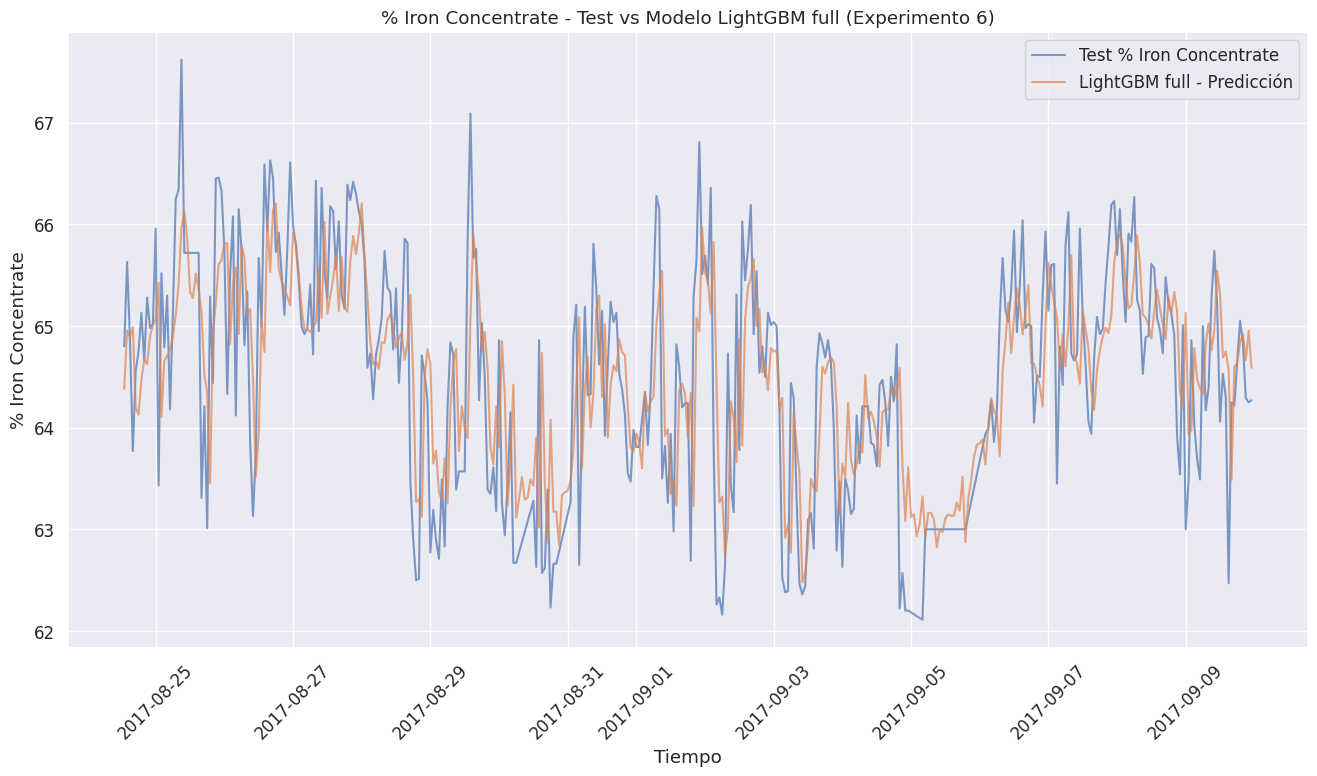

In [ ]:
# Gráficos para el modelo 2.6 LightGBM full: Test vs Modelo y curva de importancia de variables

import matplotlib.pyplot as plt

# 1) Gráfico Test vs Modelo (serie de tiempo)
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(test_labels.index, test_labels, label="Test % Iron Concentrate", alpha=0.7)
plt.plot(preds.index, preds, label="LightGBM full - Predicción", alpha=0.7)
plt.title("% Iron Concentrate - Test vs Modelo LightGBM full (Experimento 6)")
plt.xlabel("Tiempo")
plt.ylabel("% Iron Concentrate")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

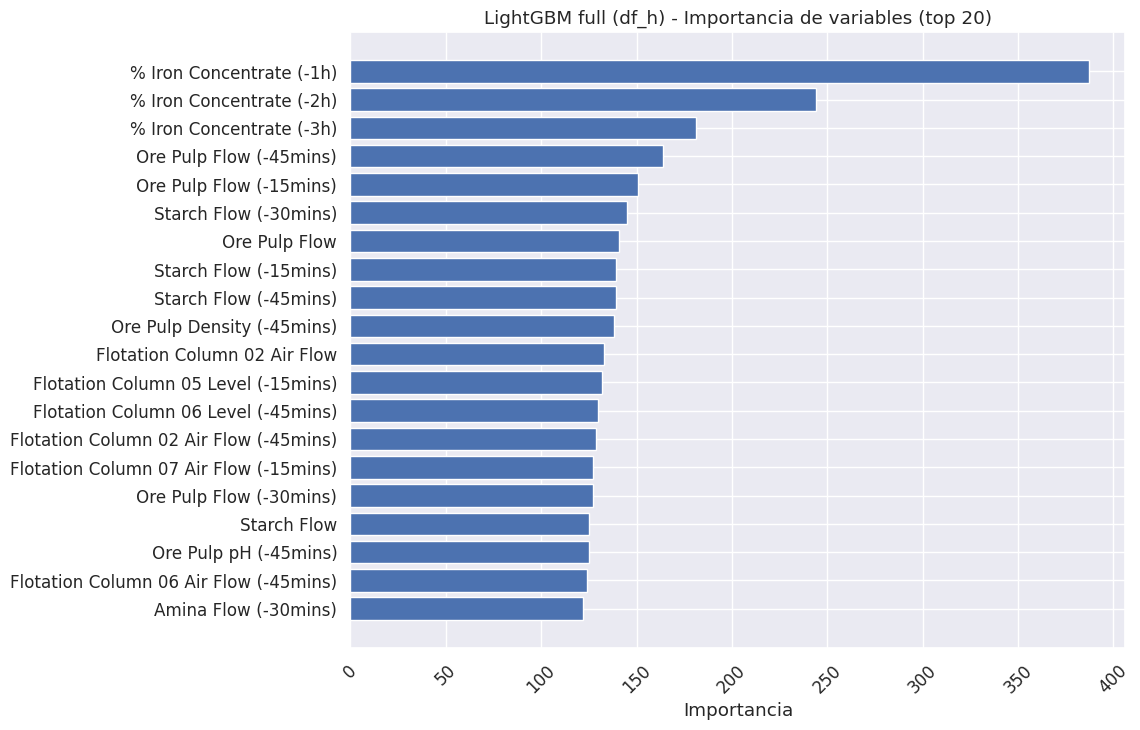

In [ ]:
# 2) Importancia de variables según LightGBM
importances = best_lgbm_full.feature_importances_
imp_df = pd.DataFrame({"feature": train_windows.columns, "importance": importances})
imp_df_sorted = imp_df.sort_values("importance", ascending=False)

top_n = 20
top_imp = imp_df_sorted.head(top_n).sort_values("importance")

plt.figure(figsize=(10, 8), dpi=100)
plt.barh(top_imp["feature"], top_imp["importance"])
plt.title("LightGBM full (df_h) - Importancia de variables (top 20)")
plt.xlabel("Importancia")
plt.xticks(rotation=45)
plt.grid(True, axis="x")
plt.show()


In [ ]:
imp_df_sorted.head(30)

,feature,importance
84,% Iron Concentrate (-1h),387
85,% Iron Concentrate (-2h),244
86,% Iron Concentrate (-3h),181
35,Ore Pulp Flow (-45mins),164
33,Ore Pulp Flow (-15mins),151
28,Starch Flow (-30mins),145
4,Ore Pulp Flow,141
29,Starch Flow (-45mins),139
27,Starch Flow (-15mins),139
41,Ore Pulp Density (-45mins),138
